In [130]:
#Importing libraries required for this project
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [131]:
#Load data from csv file to a data frame
ship_fuel_df = pd.read_csv("ship_fuel_efficiency.csv")
#print out the first 5 rows and all the columns
ship_fuel_df.head()

,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [132]:
#Checking for Null and data type of each variable
ship_fuel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB


In [133]:
#Data Cleaning
#Dropping ship_id since this is not required for the data analysis of this project
ship_fuel_df = ship_fuel_df.drop(columns=['ship_id'])
ship_fuel_df.head()

,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [134]:
#Split the dataset into inputs and output
X = ship_fuel_df.drop('CO2_emissions', axis=1)
y = ship_fuel_df['CO2_emissions']

#list of categorical columns to encode
catcolumn = ['ship_type', 'route_id','month', 'fuel_type', 'weather_conditions']

# Identify categorical columns (all of which are of type object)
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Drop the first category to prevent dummny variable trap
encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoded = encoder.fit_transform(X[catcolumn])

# DataFrame for the one-hot encoded features
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(catcolumn))

# alignment before concatenation (just in case)
X = X.reset_index(drop=True)
one_hot_df = one_hot_df.reset_index(drop=True)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([X, one_hot_df], axis=1)

# Drop the original categorical columns (which are now duplicated)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

print("Encoded DataFrame shape:", df_encoded.shape)

Encoded DataFrame shape: (1440, 23)


In [135]:
df_encoded.head()

,distance,fuel_consumption,engine_efficiency,ship_type_Oil Service Boat,ship_type_Surfer Boat,ship_type_Tanker Ship,route_id_Lagos-Apapa,route_id_Port Harcourt-Lagos,route_id_Warri-Bonny,month_August,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,fuel_type_HFO,weather_conditions_Moderate,weather_conditions_Stormy
0,132.26,3779.77,92.14,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,128.52,4461.44,92.98,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,67.30,1867.73,87.61,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,71.68,2393.51,87.42,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,134.32,4267.19,85.61,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [136]:
#Split the data into train and test set (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1152, 23)
Shape of X_test:  (288, 23)


In [137]:
#Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [138]:
#Linear Regression
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)
y_pred = LinearModel.predict(X_test)

#Calculation of R^2, MSE, MAE
Lr2 = r2_score(y_test, y_pred)
Lmse = mean_squared_error(y_test, y_pred)
Lmae = mean_absolute_error(y_test, y_pred)

print(f"R²: {Lr2}, mse: {Lmse}, mae: {Lmae}")

R²: 0.994976288601627, mse: 1043285.34590998, mae: 633.7062696955527


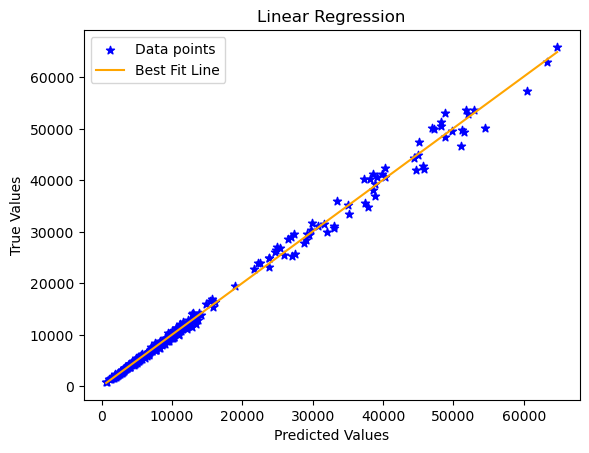

In [139]:
# Example scatter plot using predicted and actual values
plt.scatter(y_pred, y_test, marker='*', color='blue', label='Data points')

# Compute the best fit line parameters (slope and intercept)
slope, intercept = np.polyfit(y_pred, y_test, 1)

# Create x values for plotting the line. Here, we create 100 equally spaced values between the min and max of y_pred.
x_line = np.linspace(np.min(y_pred), np.max(y_pred), 100)
y_line = slope * x_line + intercept

# Plot the best fit line
plt.plot(x_line, y_line, color='orange', label='Best Fit Line')

# Add labels, legend, and show the plot
plt.title("Linear Regression")
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.show()

In [140]:
#Generatng alpha from 0 to 10 in steps of 0.001
alpha = np.arange(0,10.001,0.001)
alpha = alpha.tolist()
results = {}
#for loop to test out all the alpha values to find the best value
for a in alpha:
    #Ridge Regression
    RidgeModel = Ridge(alpha=a)
    RidgeModel.fit(X_train, y_train)
    y_pred = RidgeModel.predict(X_test)

    #Calculation of R^2, MSE, MAE
    Rr2 = r2_score(y_test, y_pred)
    Rmse = mean_squared_error(y_test, y_pred)
    Rmae = mean_absolute_error(y_test, y_pred)
    results[a] = {'R²': Rr2, 'MSE': Rmse, 'MAE': Rmae}

#Output the best performing alpha and its performance matrics. EIther maximising R² or minimising MSE. 
best_alpha_val = max(results, key=lambda a: results[a]['R²'])

print("Best alpha: ", best_alpha_val)
print("Performance for best alpha: ", results[best_alpha_val])

Best alpha:  0.0
Performance for best alpha:  {'R²': 0.994976288601627, 'MSE': 1043285.3459099792, 'MAE': 633.7062696955527}


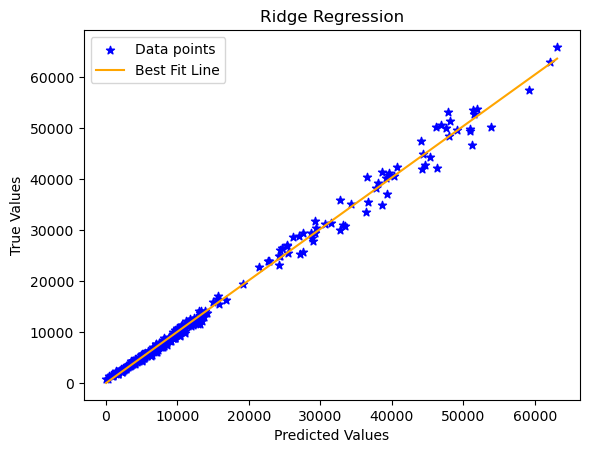

In [141]:
# Example scatter plot using predicted and actual values
plt.scatter(y_pred, y_test, marker='*', color='blue', label='Data points')

# Compute the best fit line parameters (slope and intercept)
slope, intercept = np.polyfit(y_pred, y_test, 1)

# Create x values for plotting the line. Here, we create 100 equally spaced values between the min and max of y_pred.
x_line = np.linspace(np.min(y_pred), np.max(y_pred), 100)
y_line = slope * x_line + intercept

# Plot the best fit line
plt.plot(x_line, y_line, color='orange', label='Best Fit Line')

# Add labels, legend, and show the plot
plt.title("Ridge Regression")
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.show()

In [145]:
kf = KFold(n_splits=10, shuffle=True, random_state=42) #Split the dataset into 5

# Using cross_val_score with r² as the metric
lr_scores = cross_val_score(LinearModel, df_encoded, y, cv=kf, scoring='r2')
print("Linear Regression CV R² scores:", lr_scores)
print("Mean CV R² (Linear Regression):", lr_scores.mean())

print("\n")
#Ridge Regression Evaluation
ridge_alpha = 0.0 #the best alpha value is determined by the code above
RidgeModel = Ridge(alpha=ridge_alpha)
ridge_scores = cross_val_score(RidgeModel, df_encoded, y, cv=kf, scoring='r2')
print(f"Ridge Regression (alpha={ridge_alpha}) CV R² scores:", ridge_scores)
print(f"Mean CV R² (Ridge Regression):", ridge_scores.mean())

Linear Regression CV R² scores: [0.99400899 0.99600528 0.99489961 0.99424266 0.99541399 0.99334835
 0.99343844 0.99553045 0.99376503 0.99249532]
Mean CV R² (Linear Regression): 0.9943148123097203


Ridge Regression (alpha=0.0) CV R² scores: [0.99400899 0.99600528 0.99489961 0.99424266 0.99541399 0.99334835
 0.99343844 0.99553045 0.99376503 0.99249532]
Mean CV R² (Ridge Regression): 0.9943148123097203


In [146]:
# Additional check for multicollinearity: VIF (Variance Inflation Factor)
X_with_const = add_constant(X_train)  # Add constant for intercept
feature_columns_with_const = ['const'] + list(df_encoded.columns)  # Include constant in feature names

# Compute the VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = feature_columns_with_const
vif_data["VIF"] = [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]

# Display the VIFs
print("\nVariance Inflation Factors (VIF):")
print(vif_data)


Variance Inflation Factors (VIF):
                         feature        VIF
0                          const   1.000000
1                       distance  13.199756
2               fuel_consumption  17.418582
3              engine_efficiency   1.017493
4     ship_type_Oil Service Boat   1.895232
5          ship_type_Surfer Boat   2.021843
6          ship_type_Tanker Ship   3.177959
7           route_id_Lagos-Apapa   1.502058
8   route_id_Port Harcourt-Lagos   1.521481
9           route_id_Warri-Bonny   1.439856
10                  month_August   1.767587
11                month_December   1.820539
12                month_February   1.823371
13                 month_January   1.843988
14                    month_July   1.811831
15                    month_June   1.829861
16                   month_March   1.777437
17                     month_May   1.811033
18                month_November   1.768122
19                 month_October   1.737795
20               month_September   1.8282


Correlation Matrix:
                              distance  fuel_consumption  engine_efficiency  \
distance                      1.000000          0.945100          -0.026146   
fuel_consumption              0.945100          1.000000          -0.031269   
engine_efficiency            -0.026146         -0.031269           1.000000   
ship_type_Oil Service Boat   -0.377838         -0.286033           0.073514   
ship_type_Surfer Boat        -0.200988         -0.350141          -0.010411   
ship_type_Tanker Ship         0.666889          0.763184          -0.035139   
route_id_Lagos-Apapa          0.039806          0.040644           0.008541   
route_id_Port Harcourt-Lagos -0.005237         -0.004865          -0.005975   
route_id_Warri-Bonny         -0.046715         -0.050844           0.004813   
month_August                 -0.064571         -0.053496          -0.011777   
month_December               -0.028679         -0.026885          -0.010071   
month_February                0

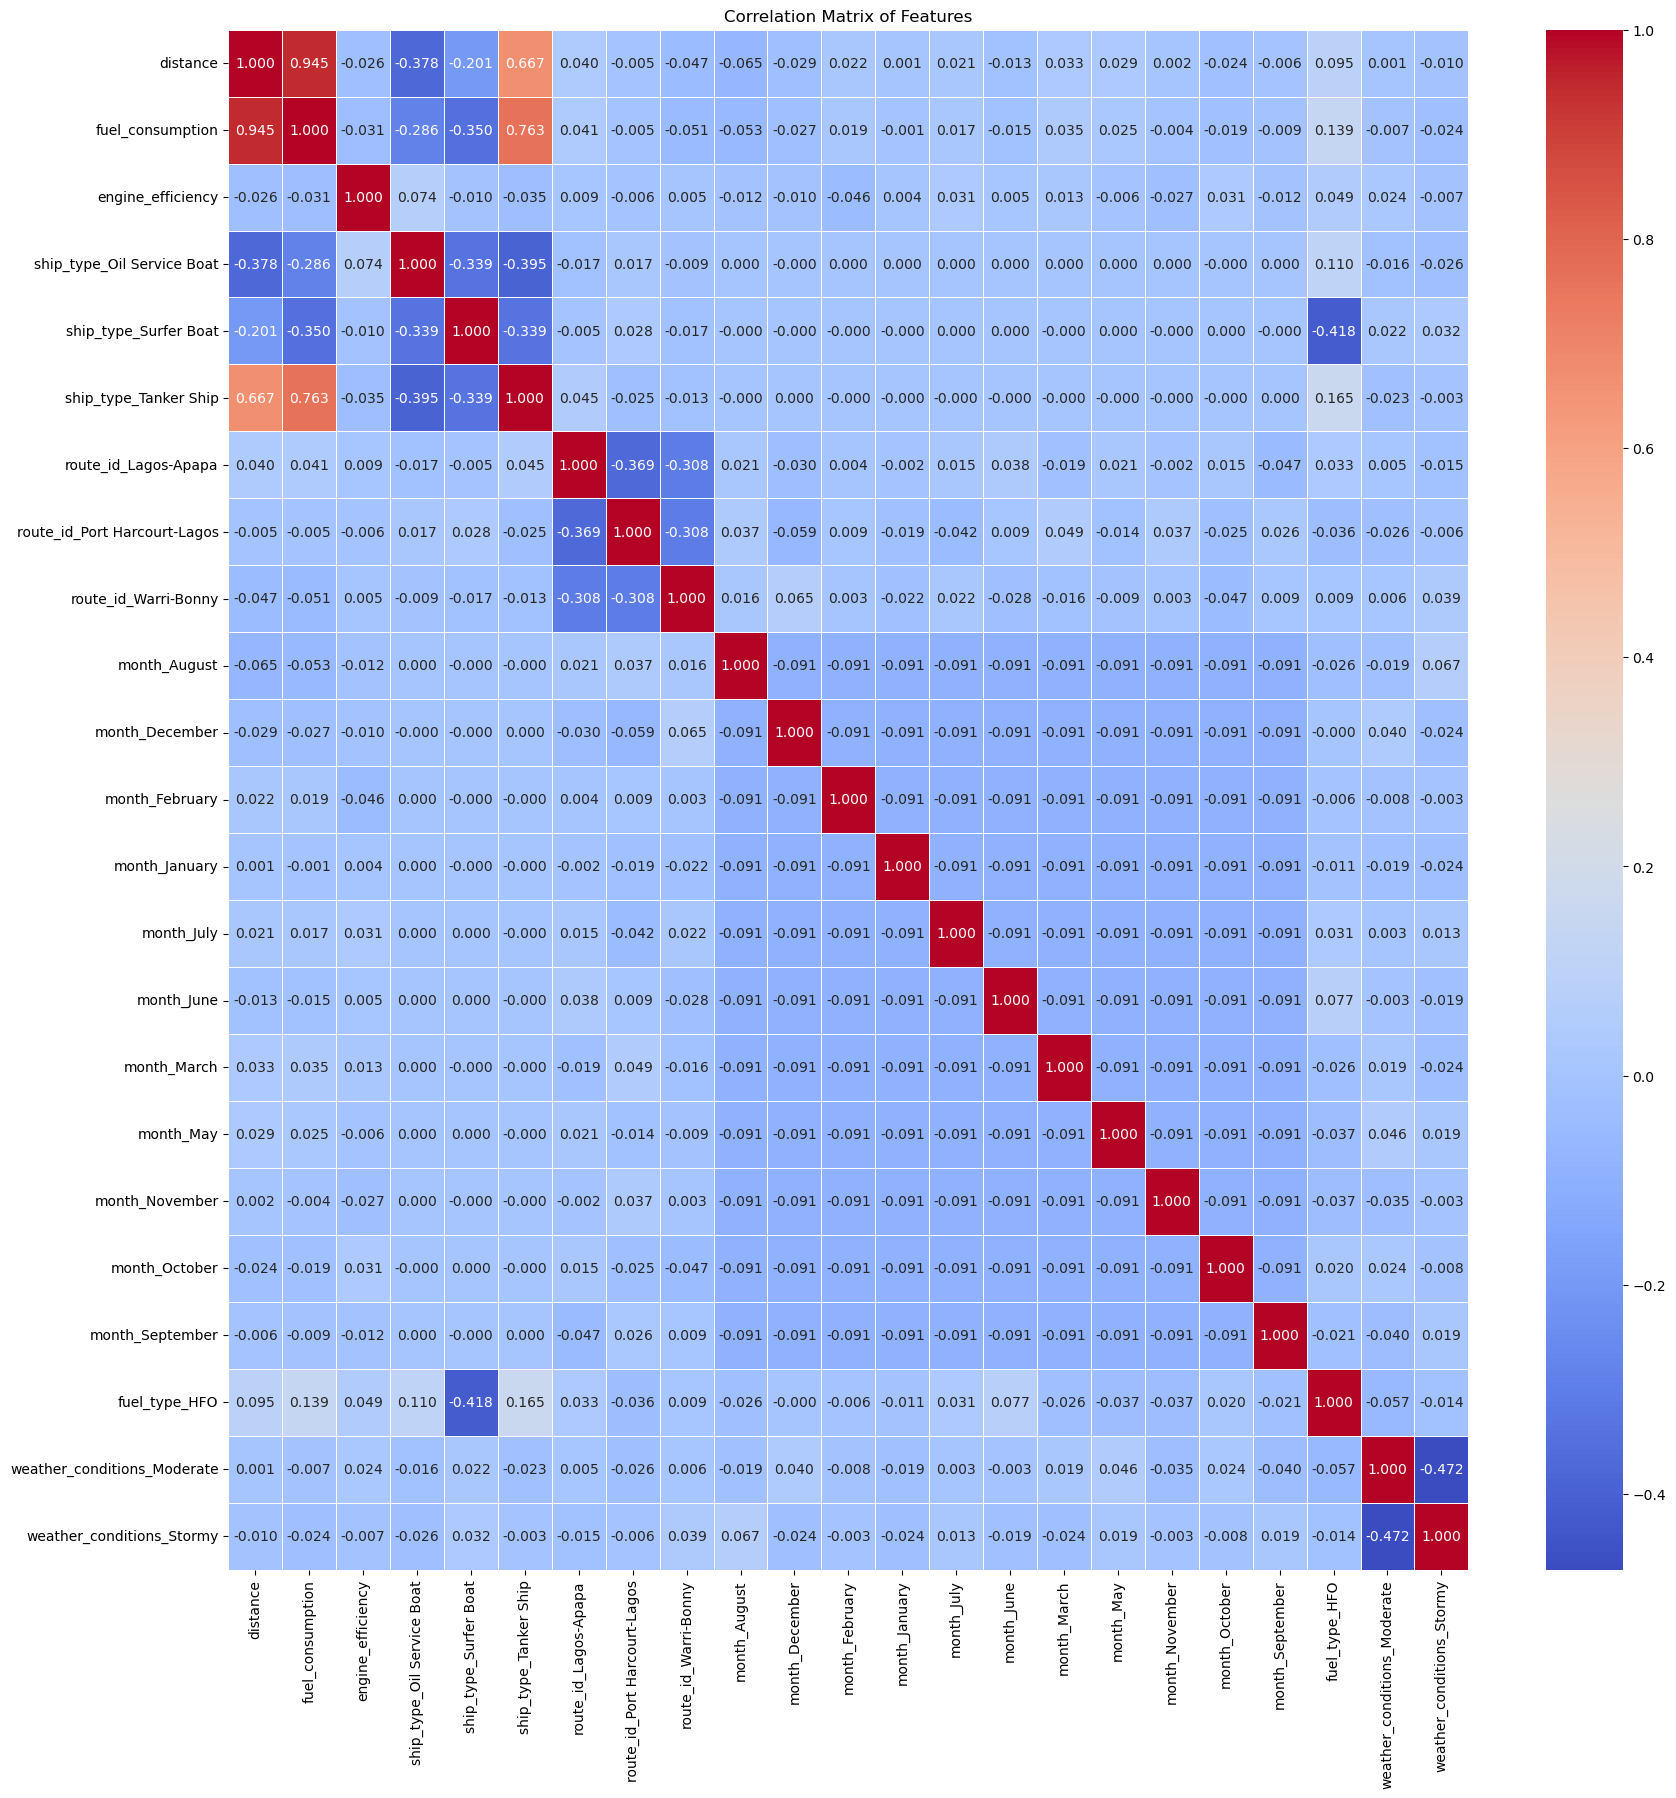


Highly Correlated Feature pairs (correlation > 0.8):
fuel_consumption and distance: 0.945


In [147]:
# Calculate the correlation matrix for the features
correlation_matrix = df_encoded.corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix for better visualization
plt.figure(figsize=(20, 20))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Identify pairs of features with high correlation (absolute value > 0.8)
high_correlation_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display highly correlated feature pairs
print("\nHighly Correlated Feature pairs (correlation > 0.8):")
for pair in high_correlation_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.3f}")